In [83]:
# import libraries
import os
import sys
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import nilearn
from nilearn.image import load_img, new_img_like
from nilearn import plotting
from nilearn import surface
import nibabel as nib
import glob
from pathlib import Path

In [17]:
HOME_DIR = str(Path.home())
PROJ_DIR = os.path.join(HOME_DIR,'Documents','Magic_fMRI','DATA','MRI')
RAWDATA_DIR = os.path.join(PROJ_DIR, 'rawdata')
FMRIPREP_DIR = os.path.join(PROJ_DIR, 'derivatives', 'fmriprep-21.0.1')
TR = 2

In [145]:
# get all subjects 
all_subjects = glob.glob(os.path.join(RAWDATA_DIR,'sub-*'))
all_subjects.sort()
subjects = [os.path.basename(sub) for sub in all_subjects]

all_sub_dicts = []

for sub in subjects:
    # get all event files and confound files from the current subject
    eventfiles = glob.glob(os.path.join(RAWDATA_DIR, sub, 'func', '*_events.tsv'))
    confoundfiles = glob.glob(os.path.join(FMRIPREP_DIR, sub, 'func', '*desc-confounds_timeseries.tsv'))
    
    # sanity check: if number of eventfiles and confoundfiles is not equal -> throw an error
    if len(eventfiles) != len(confoundfiles):
        print('Error: Not the same number of files in {}'.format(sub))
        continue
    # create empty dictionary for the correlations
    sub_dict = {'Magic': [], 'Surprise':[], 'Control':[]}
    
    # cannot iterate over eventfiles and confoundfiles, because fmriprep does no zero leading 
    # events:run-01 confounds:run-1 => sorting results in different order
    for run in range(len(eventfiles)):
        curr_events = os.path.join(RAWDATA_DIR, sub, 'func', sub+'_task-magic_run-{:02}_events.tsv'.format(run+1))
        curr_confounds = os.path.join(FMRIPREP_DIR, sub, 'func', sub+'_task-magic_run-{}_desc-confounds_timeseries.tsv'.format(run+1))
        
        event_df = pd.read_csv(curr_events,sep='\t')
        confound_df = pd.read_csv(curr_confounds,sep='\t')
        # add time to the dataframe by multiplying the index with the TR
        confound_df['timestamps']=confound_df.index*TR
        
        # go through the keys of our sub_dict and add a column for each condition to the confound_df
        for condition in sub_dict.keys():
            condition_events = event_df[event_df.trial_type.str.contains(condition)]
            # create a vector of zeros and change their values to 1 if our condition was present
            confound_df['is_'+condition] = np.zeros((len(confound_df),1))
            for idx,trial in condition_events.iterrows():
                confound_df['is_'+condition] = np.where((confound_df.timestamps>trial.onset) & (confound_df.timestamps<trial.onset+trial.duration),1,confound_df['is_'+condition])
            [corr, p] = stats.spearmanr(confound_df.framewise_displacement,confound_df['is_'+condition], nan_policy='omit')
            sub_dict[condition].append(corr)
    
    all_sub_dicts.append(sub_dict)

Error: Not the same number of files in sub-07


In [155]:
# get all subjects 
all_subjects = glob.glob(os.path.join(RAWDATA_DIR,'sub-*'))
all_subjects.sort()
subjects = [os.path.basename(sub) for sub in all_subjects]

all_sub_dicts = []

for sub in subjects:
    # get all event files and confound files from the current subject
    eventfiles = glob.glob(os.path.join(RAWDATA_DIR, sub, 'func', '*_events.tsv'))
    confoundfiles = glob.glob(os.path.join(FMRIPREP_DIR, sub, 'func', '*desc-confounds_timeseries.tsv'))
    
    # sanity check: if number of eventfiles and confoundfiles is not equal -> throw an error
    if len(eventfiles) != len(confoundfiles):
        print('Error: Not the same number of files in {}'.format(sub))
        continue
    # create empty dictionary for the correlations
    sub_dict = {'Magic': [], 'Surprise':[], 'Control':[]}
    
    # cannot iterate over eventfiles and confoundfiles, because fmriprep does no zero leading 
    # events:run-01 confounds:run-1 => sorting results in different order
    for run in range(len(eventfiles)):
        curr_events = os.path.join(RAWDATA_DIR, sub, 'func', sub+'_task-magic_run-{:02}_events.tsv'.format(run+1))
        curr_confounds = os.path.join(FMRIPREP_DIR, sub, 'func', sub+'_task-magic_run-{}_desc-confounds_timeseries.tsv'.format(run+1))
        
        event_df = pd.read_csv(curr_events,sep='\t')
        confound_df = pd.read_csv(curr_confounds,sep='\t')
        # add time to the dataframe by multiplying the index with the TR
        confound_df['timestamps']=confound_df.index*TR
        
        # go through the keys of our sub_dict and add a column for each condition to the confound_df
        for condition in sub_dict.keys():
            condition_events = event_df[event_df.trial_type.str.contains(condition)]
            # create a vector of zeros and change their values to 1 if our condition was present
            confound_df['is_'+condition] = np.zeros((len(confound_df),1))
            for idx,trial in condition_events.iterrows():
                confound_df['is_'+condition] = np.where((confound_df.timestamps>trial.onset) & (confound_df.timestamps<trial.onset+trial.duration),1,confound_df['is_'+condition])
            [corr, p] = stats.spearmanr(confound_df.global_signal,confound_df['is_'+condition], nan_policy='omit')
            sub_dict[condition].append(corr)
    
    all_sub_dicts.append(sub_dict)

Error: Not the same number of files in sub-07


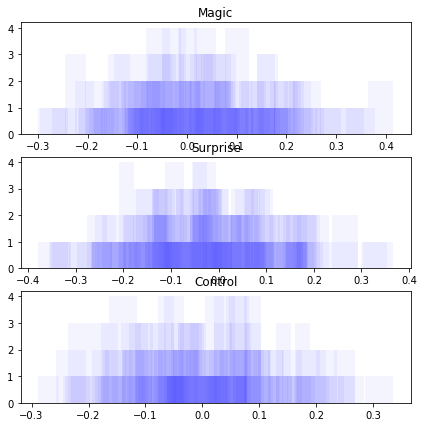

In [156]:
# plot histogram of correlations for all subjects
fig = plt.figure(figsize=(7,7))
# a plot for each condition
for c,condition in enumerate(sub_dict.keys()):
    # add new subplot
    ax = plt.subplot(3,1,c+1)
    ax.title.set_text(condition)
    for s, sub in enumerate(all_sub_dicts):
        ax.hist(sub[condition],color='b',alpha=1/len(all_sub_dicts))

In [122]:
sub = 'sub-02'
run = 3

eventfile = os.path.join(RAWDATA_DIR, sub, 'func', sub+'_task-magic_run-{:02}_events.tsv'.format(run))
confoundfile = os.path.join(FMRIPREP_DIR, sub, 'func', sub+'_task-magic_run-{}_desc-confounds_timeseries.tsv'.format(run))

event_df = pd.read_csv(eventfile,sep='\t')
surprise_events = event_df[event_df.trial_type.str.contains('Surprise')]
magic_events = event_df[event_df.trial_type.str.contains('Magic')]
control_events = event_df[event_df.trial_type.str.contains('Control')]
confound_df = pd.read_csv(confoundfile,sep='\t')
confound_df['timestamps']=confound_df.index*TR

# extend confound_df with a column containing [0,1] for either it had surprise condition or not
# use new column to convolve with HDRF
confound_df['is_surprise'] = np.zeros((len(confound_df),1))
confound_df['is_magic'] = np.zeros((len(confound_df),1))
confound_df['is_control'] = np.zeros((len(confound_df),1))

for idx,surp in surprise_events.iterrows():
    confound_df.is_surprise = np.where((confound_df.timestamps>surp.onset) & (confound_df.timestamps<surp.onset+surp.duration),1,confound_df.is_surprise)
    
for idx, con in control_events.iterrows():
    confound_df.is_control = np.where((confound_df.timestamps>con.onset) & (confound_df.timestamps<con.onset+con.duration),1,confound_df.is_control)
    
for idx, mag in magic_events.iterrows():
    confound_df.is_magic = np.where((confound_df.timestamps>mag.onset) & (confound_df.timestamps<mag.onset+mag.duration),1,confound_df.is_control)


In [125]:
stats.spearmanr(confound_df.framewise_displacement,confound_df.is_surprise, nan_policy='omit')

SpearmanrResult(correlation=-0.024739918892234602, pvalue=0.733389676967148)

In [54]:
datapoints = np.linspace(0,len(confound_df), len(confound_df))
colors = np.array([['r']*8 if 'Surprise' in trial else ['b']*8 for trial in event_df.trial_type])
colors = colors.flatten()

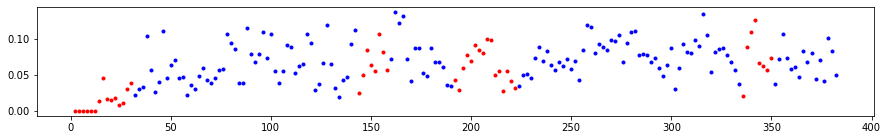

In [62]:
# plot the conditions together with confounding parameters
fig = plt.figure(figsize=(15,2))
for t, f, c in zip(confound_df.timestamps, confound_df.framewise_displacement,colors):
    plt.plot(t, f,'.',c=c)
#plt.xticks(ticks=event_df.onset, labels=event_df.trial_type, rotation=45, ha='right');